In [3]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/project_final_list'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break


In [13]:
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [15]:
jutepath = "./kag2/jute"
maizepath = "./kag2/maize"
ricepath = "./kag2/rice"
sugarcanepath = "./kag2/sugarcane"
wheatpath = "./kag2/wheat"

jutefilename = os.listdir(jutepath)
maizefilename = os.listdir(maizepath)
ricefilename = os.listdir(ricepath)
sugarcanefilename = os.listdir(sugarcanepath)
wheatfilename = os.listdir(wheatpath)

X= []

In [16]:
for fname in jutefilename:
    X.append([os.path.join(jutepath,fname),0])
for fname in maizefilename:
    X.append([os.path.join(maizepath,fname),1])
for fname in ricefilename:
    X.append([os.path.join(ricepath,fname),2])
for fname in sugarcanefilename:
    X.append([os.path.join(sugarcanepath,fname),3]) 
for fname in wheatfilename:
    X.append([os.path.join(wheatpath,fname),4])  
X = pd.DataFrame(X,columns = ['path','labels'])    

In [17]:
X.head()

,path,labels
0,./kag2/jute\jute001a.jpeg,0
1,./kag2/jute\jute001ahf.jpeg,0
2,./kag2/jute\jute001ahs.jpeg,0
3,./kag2/jute\jute001arot.jpeg,0
4,./kag2/jute\jute002a.jpeg,0


In [18]:

ohencoder = OneHotEncoder(handle_unknown='ignore',sparse=False)
ohlabel = pd.DataFrame(ohencoder.fit_transform(X[['labels']]),dtype = 'float64',columns = ['label0','label1','label2','label3','label4'])
label_X = X.copy()
X = pd.concat([X,ohlabel],axis = 1)
new_X = X.drop(['labels'],axis = 1)

C:\Users\Mohit\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [19]:
train,test = train_test_split(new_X,test_size=0.2,random_state=32,shuffle = True)

In [20]:
X_train = train['path'].values
y_train = train.drop(['path'],axis=1).values
X_test = test['path'].values
y_test = test.drop(['path'],axis=1).values

In [21]:
def deep_pipeline(data):
    flat = []
    for i in data:
        img = plt.imread(i)
        img = img/255.
        flat.append(img)
    flat =  np.array(flat)    
    flat = flat.reshape(-1,224,224,3)       
    return flat
    

In [22]:
dx_train = deep_pipeline(X_train)
dx_test = deep_pipeline(X_test)

In [23]:
import tensorflow as tf 
import keras 
from keras.layers import Conv2D,MaxPool2D,Flatten,Dense
from keras.models import Sequential,Model
from keras.preprocessing.image import ImageDataGenerator

In [24]:
vgg = keras.applications.VGG19(input_shape=(224,224,3),include_top=False,weights = 'imagenet',pooling='avg')
vgg.trainable = False
vggmodel = keras.Sequential([vgg
                         ,Dense(1000,activation='tanh'),Dense(1000,activation='tanh'),Dense(1000,activation='tanh'),Dense(5,activation='softmax')])

vggmodel.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics=['accuracy'])
vggmodel.summary()



80134624/80134624 [==============================] - 88s 1us/step

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 dense (Dense)               (None, 1000)              513000    
                                                                 
 dense_1 (Dense)             (None, 1000)              1001000   
                                                                 
 dense_2 (Dense)             (None, 1000)              1001000   
                                                                 
 dense_3 (Dense)             (None, 5)                 5005      
                                                                 
Total params: 22544389 (86.00 MB)
Trainable params: 2520005 (9.61 MB)
Non-trainable params: 20024384 (76.39 MB)
_______

In [25]:
hist = vggmodel.fit(dx_train,y_train,epochs=50,validation_split=0.3,batch_size=16)

Epoch 1/50


29/29 [==============================] - 172s 6s/step - loss: 3.1343 - accuracy: 0.2556 - val_loss: 1.5388 - val_accuracy: 0.3472
Epoch 2/50
29/29 [==============================] - 162s 6s/step - loss: 1.3065 - accuracy: 0.4511 - val_loss: 1.1132 - val_accuracy: 0.5440
Epoch 3/50
29/29 [==============================] - 163s 6s/step - loss: 0.9049 - accuracy: 0.6244 - val_loss: 0.8345 - val_accuracy: 0.6269
Epoch 4/50
29/29 [==============================] - 163s 6s/step - loss: 0.8190 - accuracy: 0.6711 - val_loss: 0.7739 - val_accuracy: 0.7047
Epoch 5/50
29/29 [==============================] - 163s 6s/step - loss: 0.6454 - accuracy: 0.7711 - val_loss: 0.7205 - val_accuracy: 0.7202
Epoch 6/50
29/29 [==============================] - 163s 6s/step - loss: 0.5811 - accuracy: 0.7844 - val_loss: 0.7675 - val_accuracy: 0.6943
Epoch 7/50
29/29 [==============================] - 162s 6s/step - loss: 0.6104 - accuracy: 0.7956 - val_loss: 1.5539 - val_accuracy: 0.5337
Epoch 8/50


In [26]:
score = vggmodel.evaluate(dx_test,y_test)
print("accuracy: ", score[1])

6/6 [==============================] - 33s 5s/step - loss: 0.2496 - accuracy: 0.9565
accuracy:  0.95652174949646


In [27]:
pred = vggmodel.predict(dx_test)
prediction = np.argmax(pred,axis=1)
true = np.argmax(y_test,axis=1)
best_prob = [pred[num,:][i] for num,i in enumerate(prediction)]

6/6 [==============================] - 44s 6s/step


In [28]:
def deepmodelpipeline(imagepath,model = vggmodel,label=[-1]):
    pdict = {0:"jute",1:"maize",2:"rice",3:"sugarcane",4:"wheat"}
    pred_x = deep_pipeline([imagepath])
    prediction = model.predict(pred_x)
    pred = np.argmax(prediction[0])
    plt.imshow(plt.imread(imagepath))
    if (label[0]!=-1):
        plt.title("prediction : {0} % {1:.2f} \ntrue        : {2}".format(pdict[pred],prediction[0,pred]*100,pdict[np.argmax(label)]))
    else:
        plt.title("prediction : {0}, % {1:.2f}".format(pdict[pred],prediction[0,pred]*100))

1/1 [==============================] - 1s 980ms/step


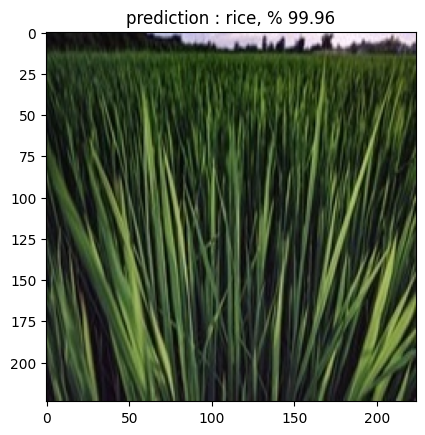

In [30]:
deepmodelpipeline('kag2/rice/rice024ahs.jpeg')

1/1 [==============================] - 0s 276ms/step


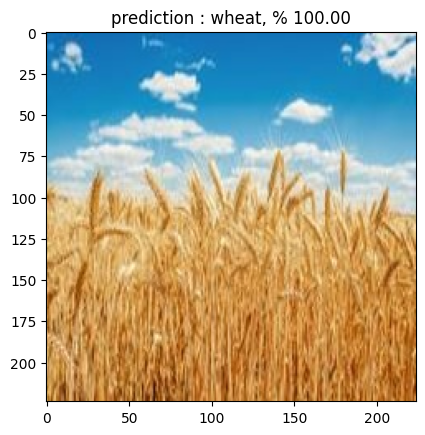

In [32]:
deepmodelpipeline('kag2/wheat/wheat0004a.jpeg')

1/1 [==============================] - 0s 250ms/step


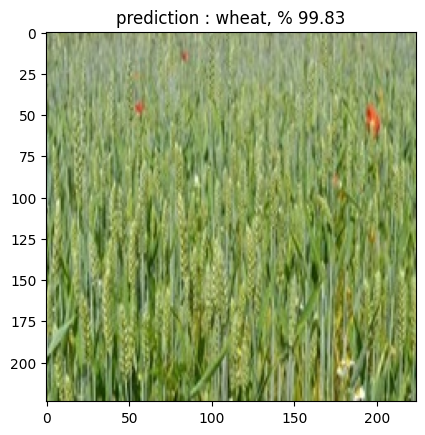

In [36]:
deepmodelpipeline('kag2/wheat/wheat022a.jpeg')

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv("crop_production.csv")
df[:5]

,State_Name,District_Name,Crop_Year,Season,Crop,Area,Production
0,Andaman and Nicobar Islands,NICOBARS,2000,Kharif,Arecanut,1254.0,2000.0
1,Andaman and Nicobar Islands,NICOBARS,2000,Kharif,Other Kharif pulses,2.0,1.0
2,Andaman and Nicobar Islands,NICOBARS,2000,Kharif,Rice,102.0,321.0
3,Andaman and Nicobar Islands,NICOBARS,2000,Whole Year,Banana,176.0,641.0
4,Andaman and Nicobar Islands,NICOBARS,2000,Whole Year,Cashewnut,720.0,165.0


In [3]:
df.isnull().sum()

State_Name          0
District_Name       0
Crop_Year           0
Season              0
Crop                0
Area                0
Production       3730
dtype: int64

In [4]:
# Droping Nan Values
data = df.dropna()
print(data.shape)
test = df[~df["Production"].notna()].drop("Production",axis=1)
print(test.shape)

(242361, 7)
(3730, 6)


In [5]:
for i in data.columns:
    print("column name :",i)
    print("No. of column :",len(data[i].unique()))
    print(data[i].unique())

column name : State_Name
No. of column : 33
['Andaman and Nicobar Islands' 'Andhra Pradesh' 'Arunachal Pradesh'
 'Assam' 'Bihar' 'Chandigarh' 'Chhattisgarh' 'Dadra and Nagar Haveli'
 'Goa' 'Gujarat' 'Haryana' 'Himachal Pradesh' 'Jammu and Kashmir '
 'Jharkhand' 'Karnataka' 'Kerala' 'Madhya Pradesh' 'Maharashtra' 'Manipur'
 'Meghalaya' 'Mizoram' 'Nagaland' 'Odisha' 'Puducherry' 'Punjab'
 'Rajasthan' 'Sikkim' 'Tamil Nadu' 'Telangana ' 'Tripura' 'Uttar Pradesh'
 'Uttarakhand' 'West Bengal']
column name : District_Name
No. of column : 646
['NICOBARS' 'NORTH AND MIDDLE ANDAMAN' 'SOUTH ANDAMANS' 'ANANTAPUR'
 'CHITTOOR' 'EAST GODAVARI' 'GUNTUR' 'KADAPA' 'KRISHNA' 'KURNOOL'
 'PRAKASAM' 'SPSR NELLORE' 'SRIKAKULAM' 'VISAKHAPATANAM' 'VIZIANAGARAM'
 'WEST GODAVARI' 'ANJAW' 'CHANGLANG' 'DIBANG VALLEY' 'EAST KAMENG'
 'EAST SIANG' 'KURUNG KUMEY' 'LOHIT' 'LONGDING' 'LOWER DIBANG VALLEY'
 'LOWER SUBANSIRI' 'NAMSAI' 'PAPUM PARE' 'TAWANG' 'TIRAP' 'UPPER SIANG'
 'UPPER SUBANSIRI' 'WEST KAMENG' 'WEST SIANG

In [6]:
data[:5]

,State_Name,District_Name,Crop_Year,Season,Crop,Area,Production
0,Andaman and Nicobar Islands,NICOBARS,2000,Kharif,Arecanut,1254.0,2000.0
1,Andaman and Nicobar Islands,NICOBARS,2000,Kharif,Other Kharif pulses,2.0,1.0
2,Andaman and Nicobar Islands,NICOBARS,2000,Kharif,Rice,102.0,321.0
3,Andaman and Nicobar Islands,NICOBARS,2000,Whole Year,Banana,176.0,641.0
4,Andaman and Nicobar Islands,NICOBARS,2000,Whole Year,Cashewnut,720.0,165.0


<Axes: xlabel='Crop_Year', ylabel='Production'>

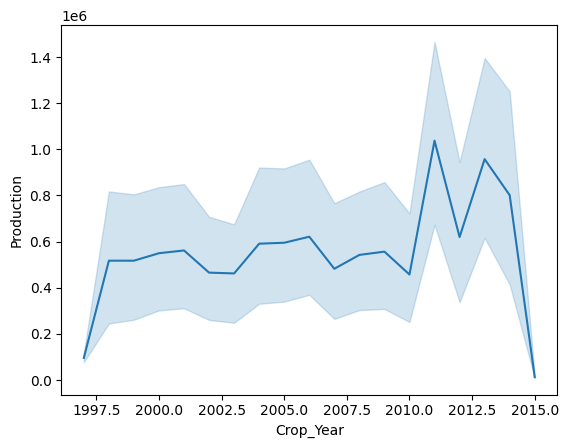

In [7]:
# Plotting the lineplot
sns.lineplot(x=data["Crop_Year"], y=data["Production"])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 [Text(0, 0, 'Andaman and Nicobar Islands'),
  Text(1, 0, 'Andhra Pradesh'),
  Text(2, 0, 'Arunachal Pradesh'),
  Text(3, 0, 'Assam'),
  Text(4, 0, 'Bihar'),
  Text(5, 0, 'Chandigarh'),
  Text(6, 0, 'Chhattisgarh'),
  Text(7, 0, 'Dadra and Nagar Haveli'),
  Text(8, 0, 'Goa'),
  Text(9, 0, 'Gujarat'),
  Text(10, 0, 'Haryana'),
  Text(11, 0, 'Himachal Pradesh'),
  Text(12, 0, 'Jammu and Kashmir '),
  Text(13, 0, 'Jharkhand'),
  Text(14, 0, 'Karnataka'),
  Text(15, 0, 'Kerala'),
  Text(16, 0, 'Madhya Pradesh'),
  Text(17, 0, 'Maharashtra'),
  Text(18, 0, 'Manipur'),
  Text(19, 0, 'Meghalaya'),
  Text(20, 0, 'Mizoram'),
  Text(21, 0, 'Nagaland'),
  Text(22, 0, 'Odisha'),
  Text(23, 0, 'Puducherry'),
  Text(24, 0, 'Punjab'),
  Text(25, 0, 'Rajasthan'),
  Text(26, 0, 'Sikkim'),
  Text(27, 0, 'Tamil Nadu'),
  Text(28, 0, 'Telangana '),
  Text(29

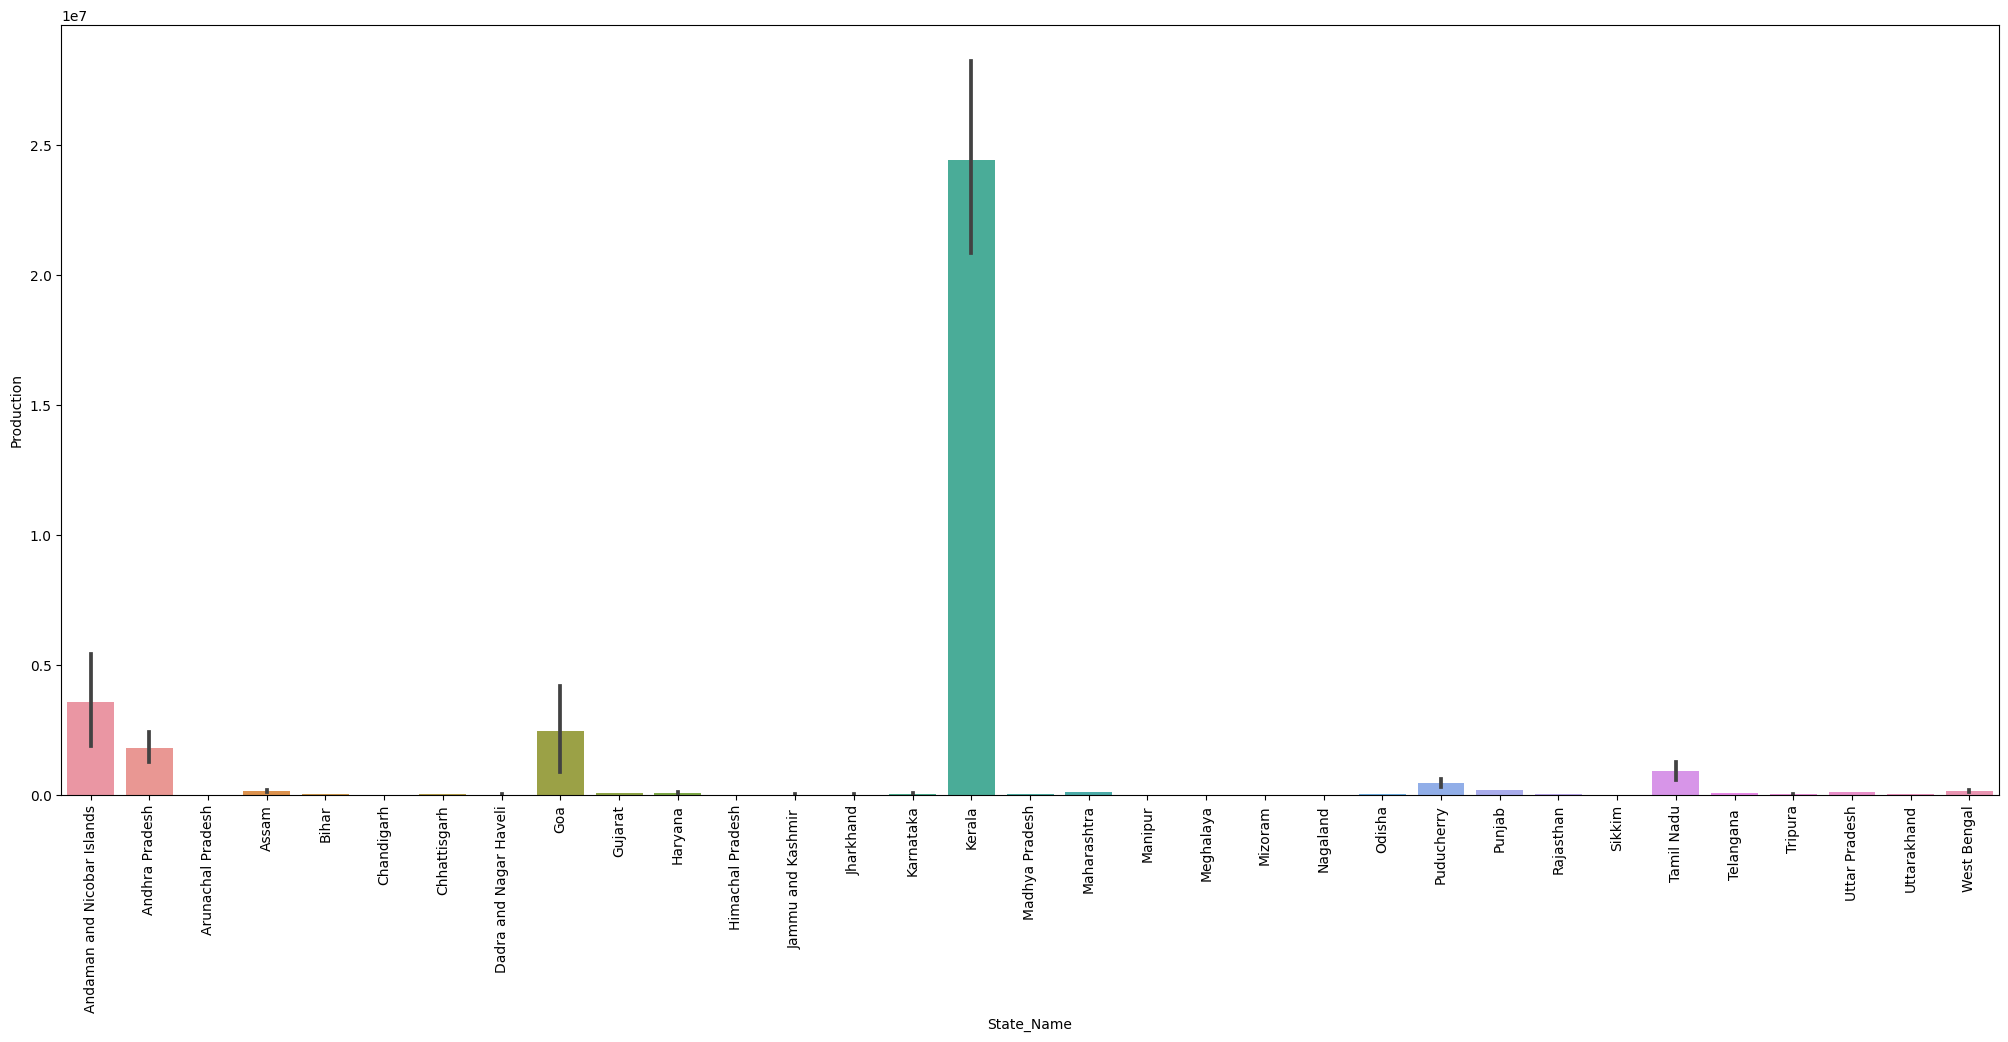

In [8]:
plt.figure(figsize=(25,10))
sns.barplot(x="State_Name", y="Production", data=data)
plt.xticks(rotation=90)


<Axes: xlabel='Season', ylabel='Production'>

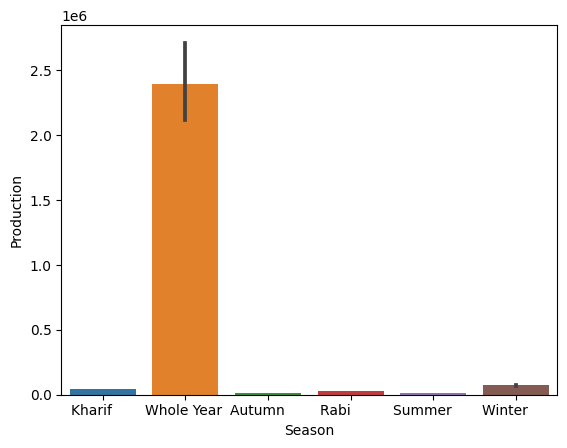

In [9]:
sns.barplot(x="Season", y="Production", data=data)

In [10]:
data.groupby("Season",axis=0).agg({"Production":np.sum})

,Production
Season,
Autumn,6.441377e+07
Kharif,4.029970e+09
Rabi,2.051688e+09
Summer,1.706579e+08
Whole Year,1.344248e+11
Winter,4.345498e+08


In [11]:
data["Crop"].value_counts()[:5]

Crop
Rice                 15082
Maize                13787
Moong(Green Gram)    10106
Urad                  9710
Sesamum               8821
Name: count, dtype: int64

In [12]:
top_crop_pro = data.groupby("Crop")["Production"].sum().reset_index().sort_values(by='Production',ascending=False)
top_crop_pro[:5]

,Crop,Production
28,Coconut,1.299816e+11
106,Sugarcane,5.535682e+09
95,Rice,1.605470e+09
119,Wheat,1.332826e+09
87,Potato,4.248263e+08


In [13]:
rice_df = data[data["Crop"]=="Rice"]
print(rice_df.shape)
rice_df[:3]

(15082, 7)


,State_Name,District_Name,Crop_Year,Season,Crop,Area,Production
2,Andaman and Nicobar Islands,NICOBARS,2000,Kharif,Rice,102.0,321.00
12,Andaman and Nicobar Islands,NICOBARS,2001,Kharif,Rice,83.0,300.00
18,Andaman and Nicobar Islands,NICOBARS,2002,Kharif,Rice,189.2,510.84


<Axes: xlabel='Season', ylabel='Production'>

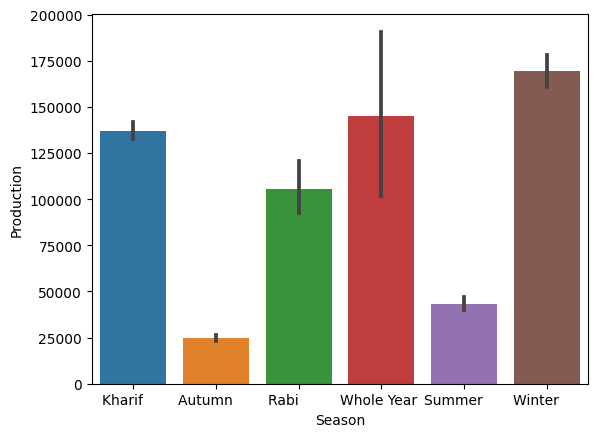

In [14]:
sns.barplot(x="Season",y="Production",data=rice_df)

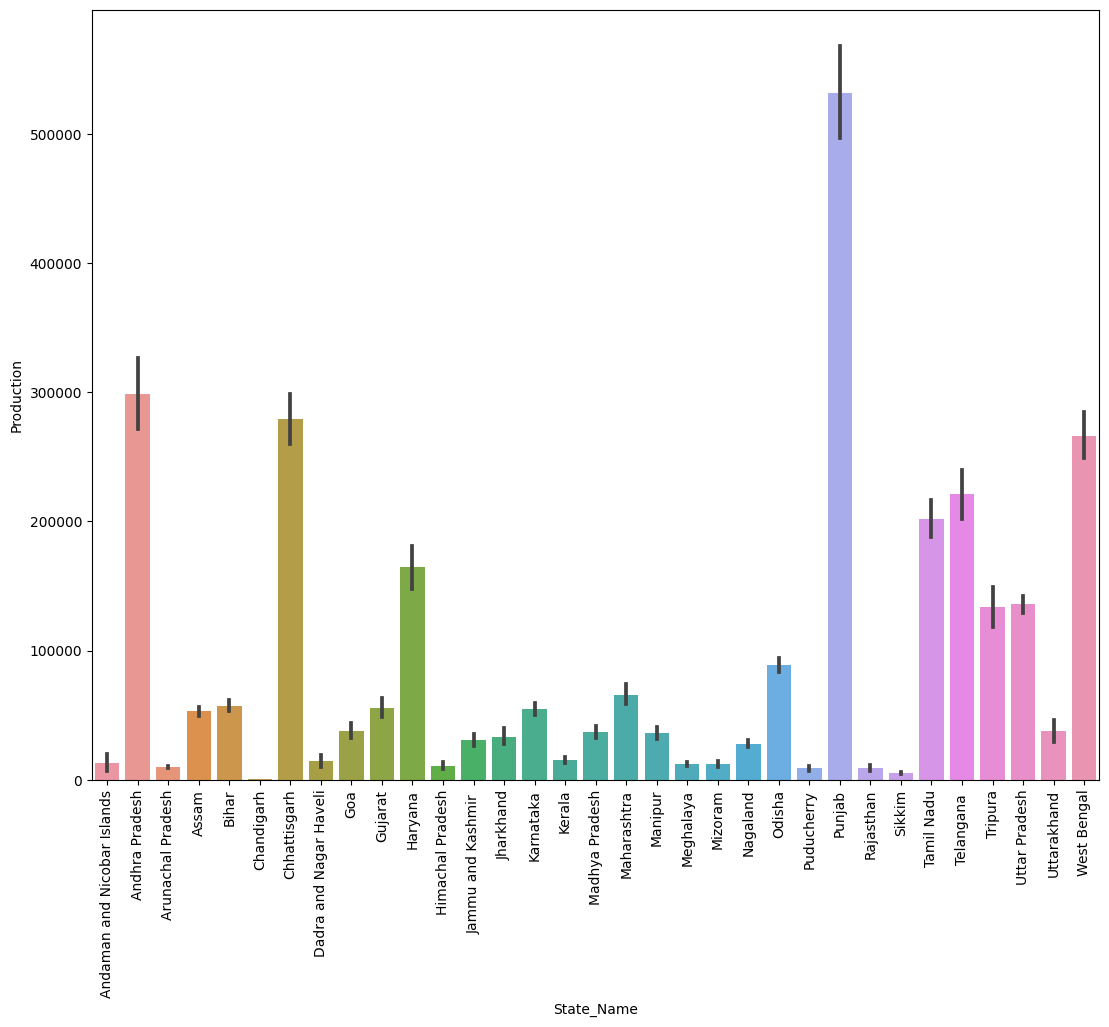

In [15]:
plt.figure(figsize=(13,10))
sns.barplot(x="State_Name",y="Production",data=rice_df)
plt.xticks(rotation=90)
plt.show()

In [16]:
top_rice_pro_dis = rice_df.groupby("District_Name")["Production"].sum().reset_index().sort_values(
    by='Production',ascending=False)
top_rice_pro_dis[:5]
sum_max = top_rice_pro_dis["Production"].sum()
top_rice_pro_dis["precent_of_pro"] = top_rice_pro_dis["Production"].map(lambda x:(x/sum_max)*100)
top_rice_pro_dis[:5]

,District_Name,Production,precent_of_pro
58,BARDHAMAN,34239976.0,2.132707
374,MEDINIPUR WEST,29192719.0,1.818328
612,WEST GODAVARI,27845309.0,1.734402
169,EAST GODAVARI,24690929.0,1.537925
494,SANGRUR,24448000.0,1.522794


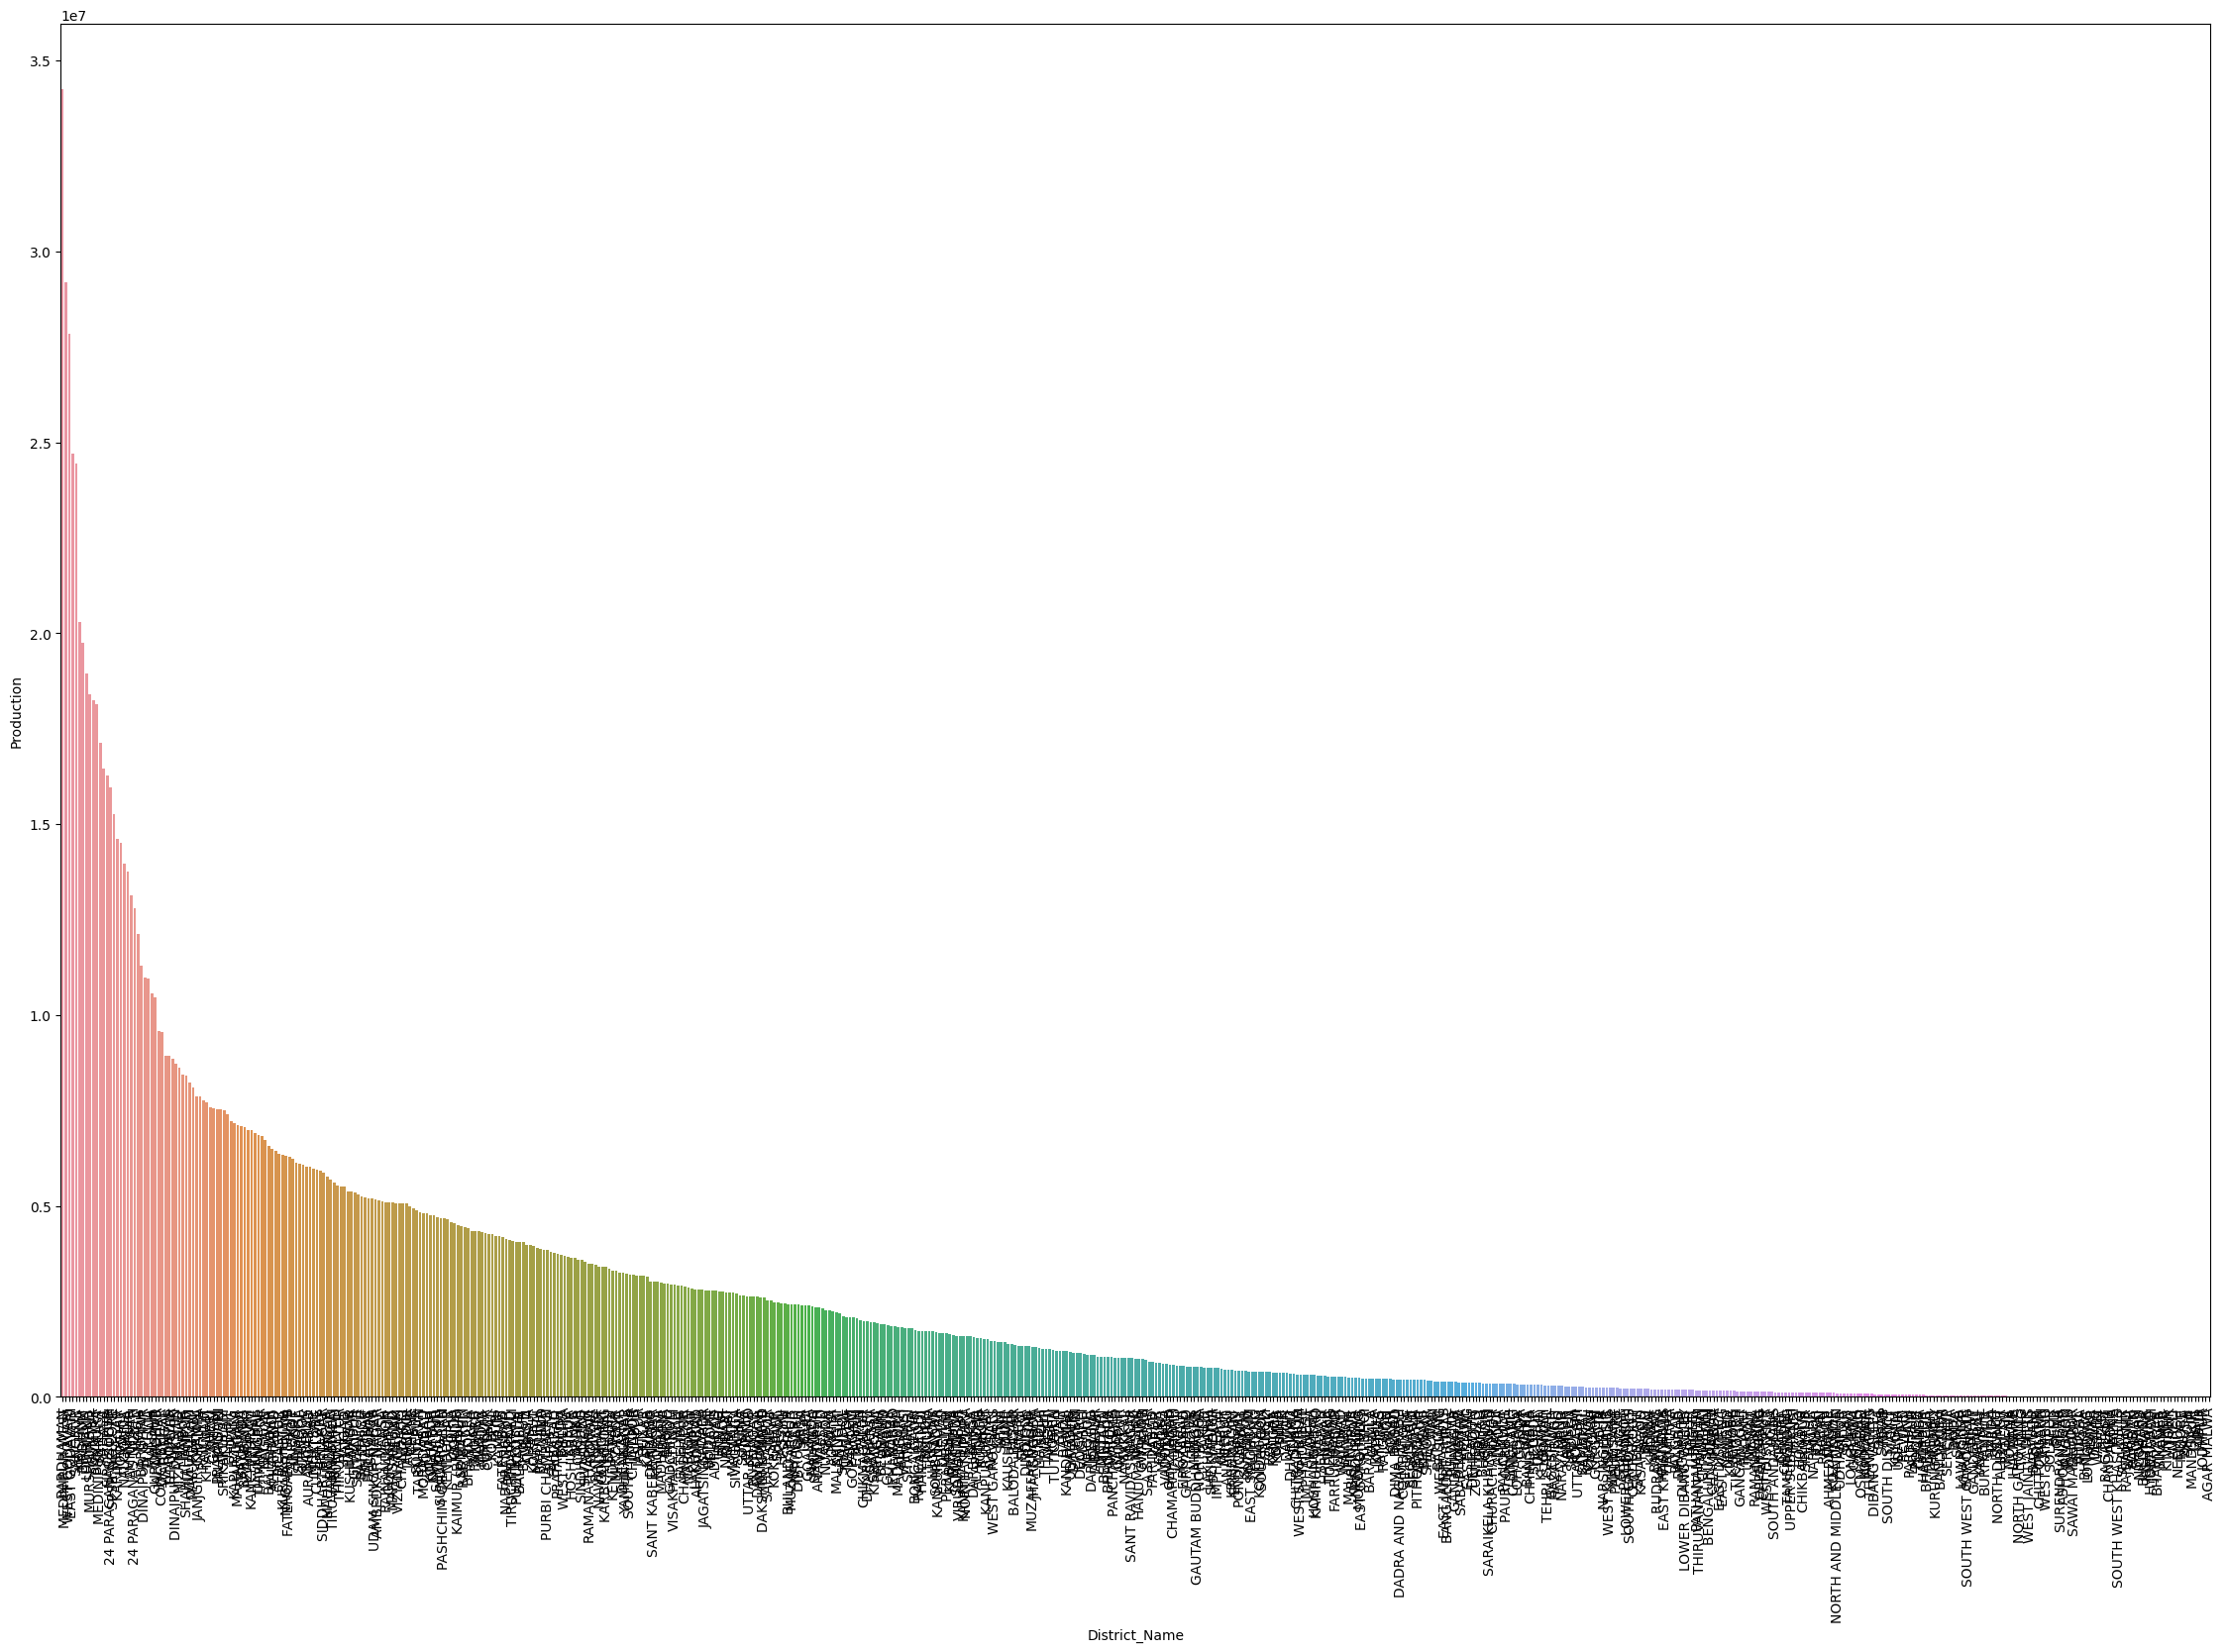

In [17]:
plt.figure(figsize=(28,18))
sns.barplot(x="District_Name",y="Production",data=top_rice_pro_dis)
plt.xticks(rotation=90)
plt.show()

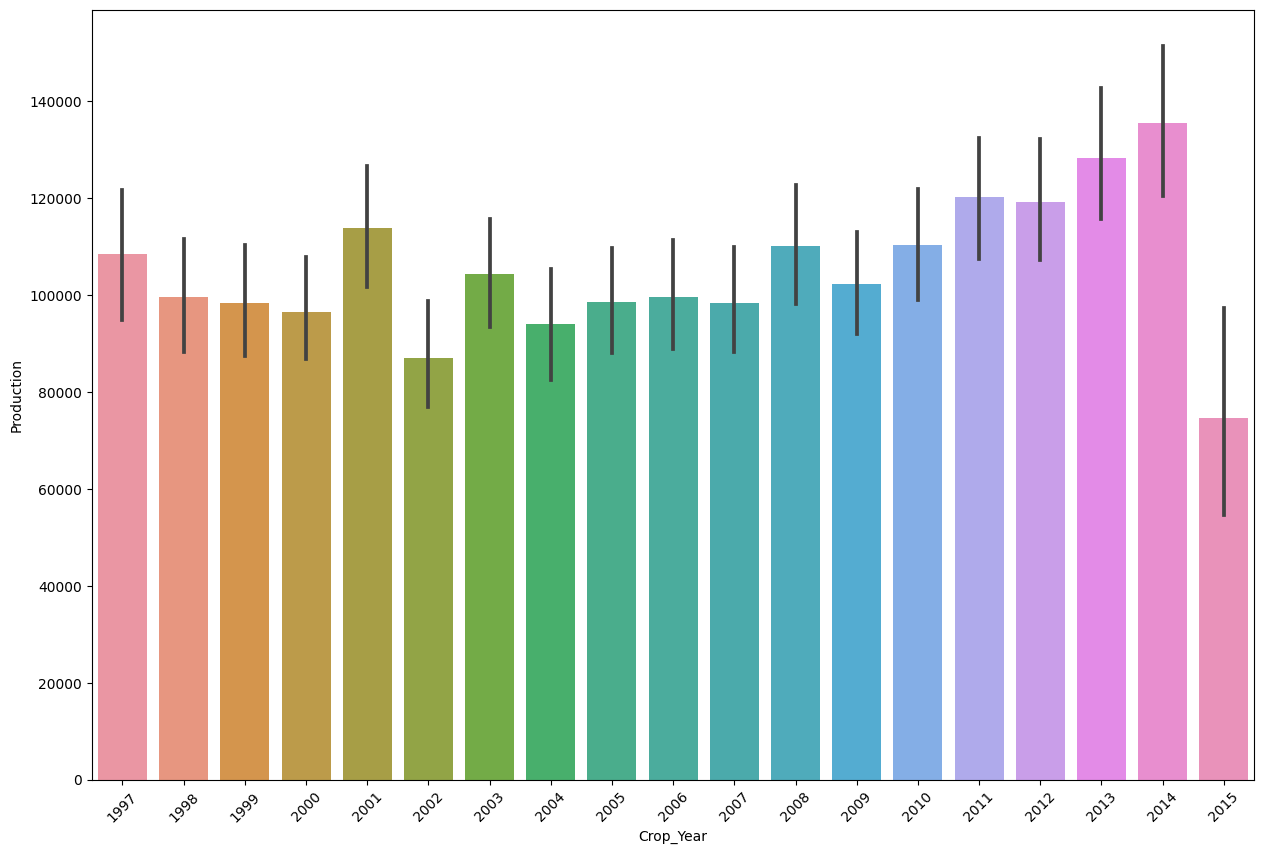

In [18]:
plt.figure(figsize=(15,10))
sns.barplot(x="Crop_Year",y="Production",data=rice_df)
plt.xticks(rotation=45)
#plt.legend(rice_df['State_Name'].unique())
plt.show()

In [19]:
coc_df = data[data["Crop"]=="Coconut "]
print(coc_df.shape)
coc_df[:3]

(1958, 7)


,State_Name,District_Name,Crop_Year,Season,Crop,Area,Production
5,Andaman and Nicobar Islands,NICOBARS,2000,Whole Year,Coconut,18168.0,65100000.0
14,Andaman and Nicobar Islands,NICOBARS,2001,Whole Year,Coconut,18190.0,64430000.0
23,Andaman and Nicobar Islands,NICOBARS,2002,Whole Year,Coconut,18240.0,67490000.0


<Axes: xlabel='Season', ylabel='Production'>

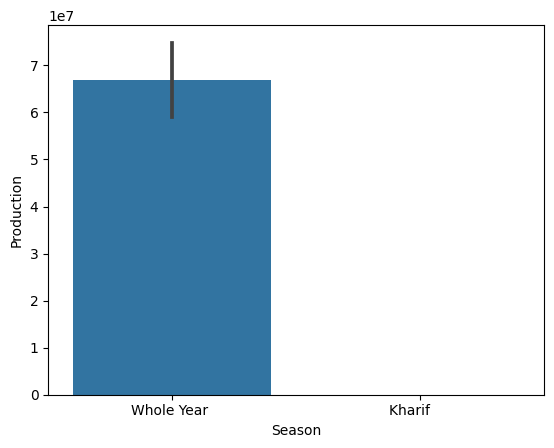

In [20]:
sns.barplot(x="Season",y="Production",data=coc_df)

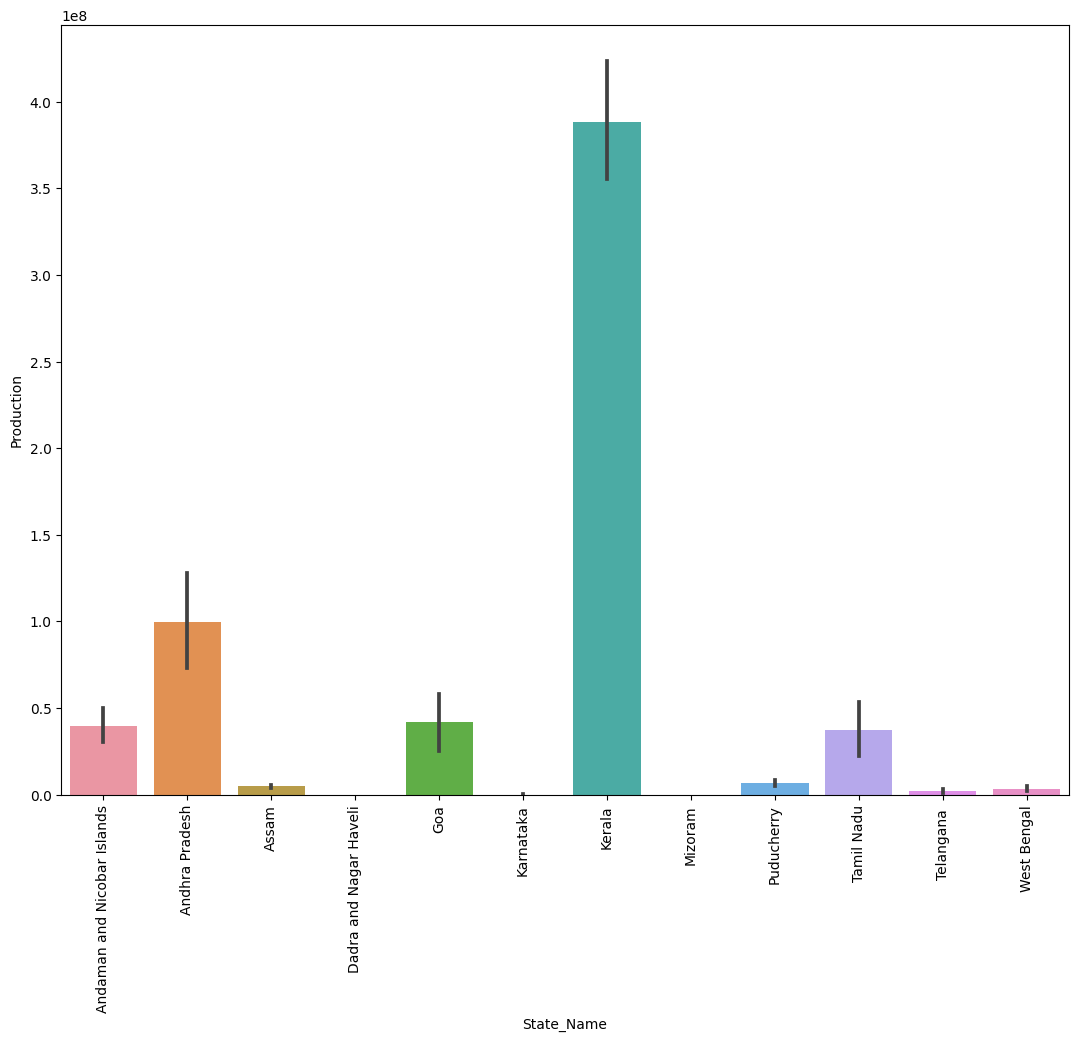

In [21]:
plt.figure(figsize=(13,10))
sns.barplot(x="State_Name",y="Production",data=coc_df)
plt.xticks(rotation=90)
plt.show()

In [22]:
top_coc_pro_dis = coc_df.groupby("District_Name")["Production"].sum().reset_index().sort_values(
    by='Production',ascending=False)
top_coc_pro_dis[:5]
sum_max = top_coc_pro_dis["Production"].sum()
top_coc_pro_dis["precent_of_pro"] = top_coc_pro_dis["Production"].map(lambda x:(x/sum_max)*100)
top_coc_pro_dis[:5]

,District_Name,Production,precent_of_pro
77,KOZHIKODE,1.527871e+10,11.754512
86,MALAPPURAM,1.451252e+10,11.165052
129,THIRUVANANTHAPURAM,1.001337e+10,7.703678
131,THRISSUR,9.920739e+09,7.632416
64,KANNUR,9.780310e+09,7.524379


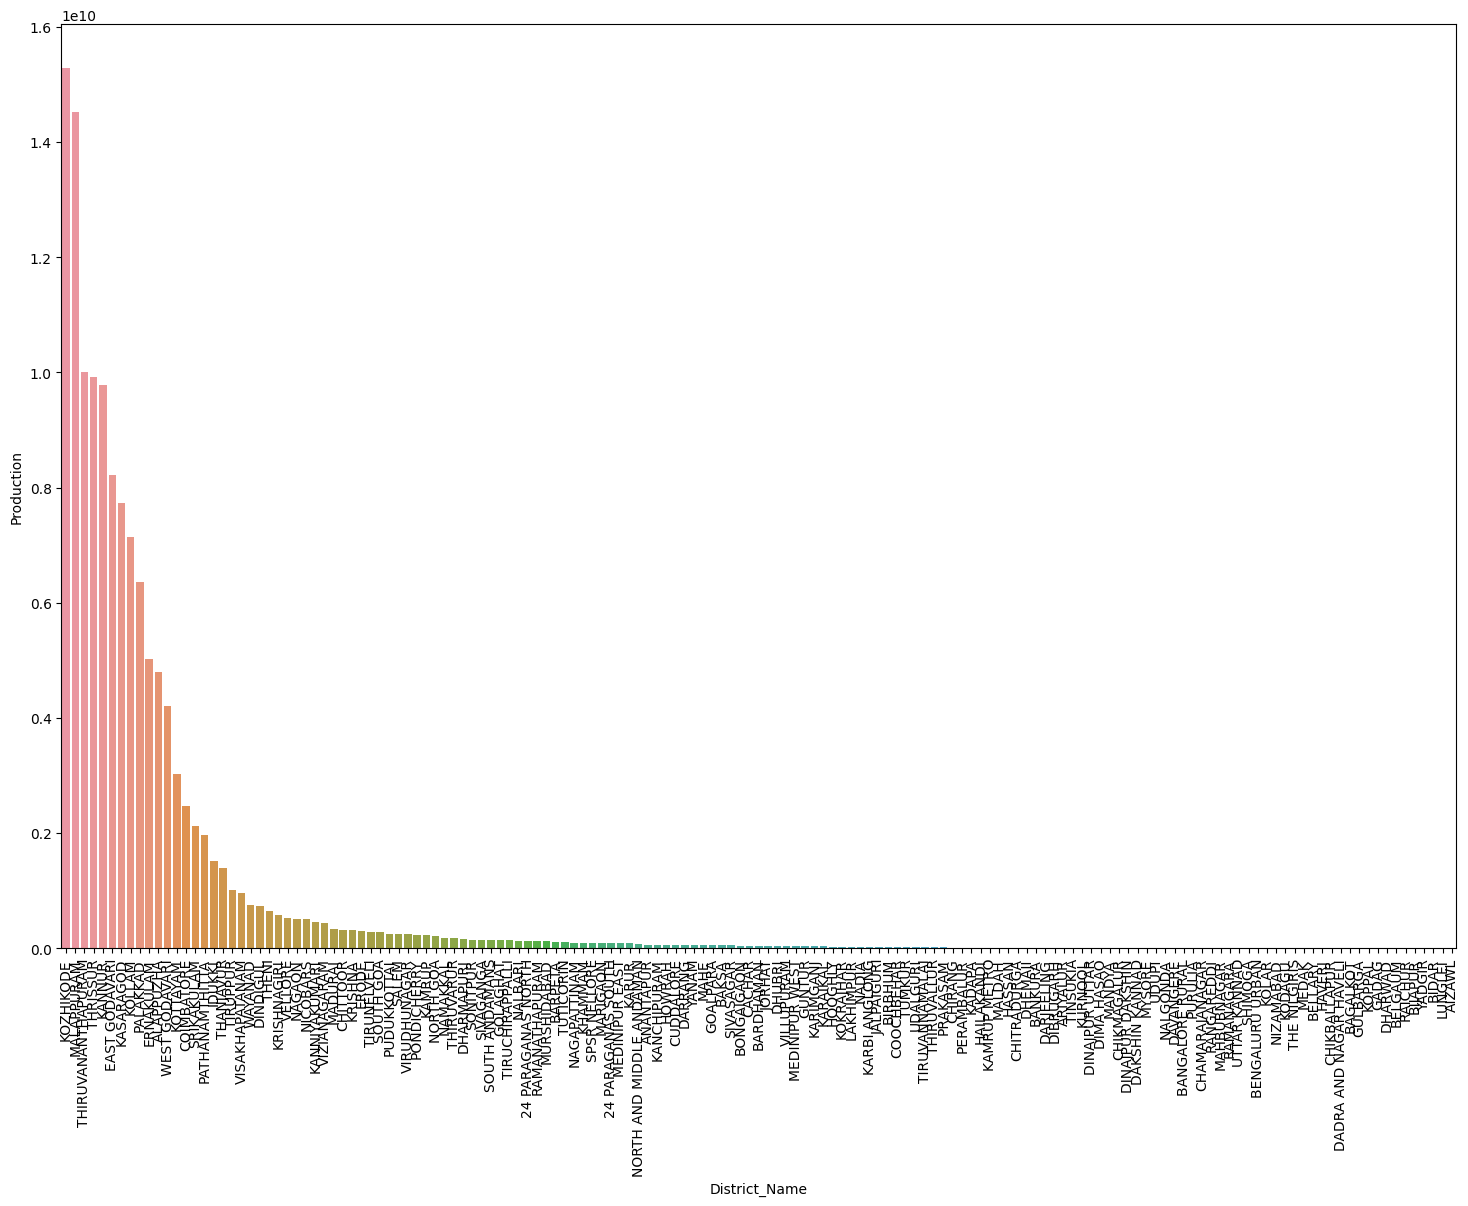

In [23]:
plt.figure(figsize=(18,12))
sns.barplot(x="District_Name",y="Production",data=top_coc_pro_dis)
plt.xticks(rotation=90)
plt.show()

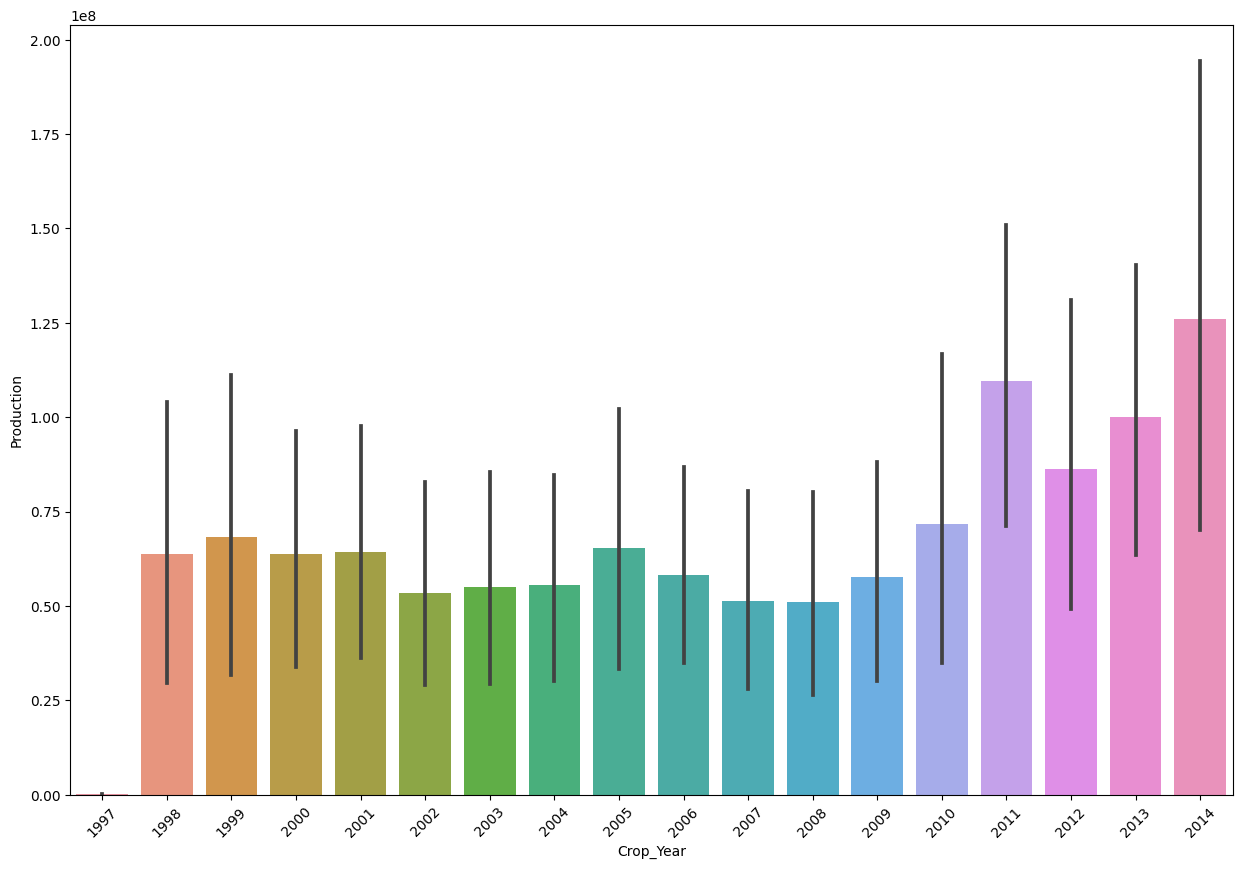

In [24]:
plt.figure(figsize=(15,10))
sns.barplot(x="Crop_Year",y="Production",data=coc_df)
plt.xticks(rotation=45)
#plt.legend(rice_df['State_Name'].unique())
plt.show()

In [25]:
sug_df = data[data["Crop"]=="Sugarcane"]
print(sug_df.shape)
sug_df[:3]

(7827, 7)


,State_Name,District_Name,Crop_Year,Season,Crop,Area,Production
7,Andaman and Nicobar Islands,NICOBARS,2000,Whole Year,Sugarcane,1.0,2.0
16,Andaman and Nicobar Islands,NICOBARS,2001,Whole Year,Sugarcane,1.0,1.0
26,Andaman and Nicobar Islands,NICOBARS,2002,Whole Year,Sugarcane,5.0,40.0


<Axes: xlabel='Season', ylabel='Production'>

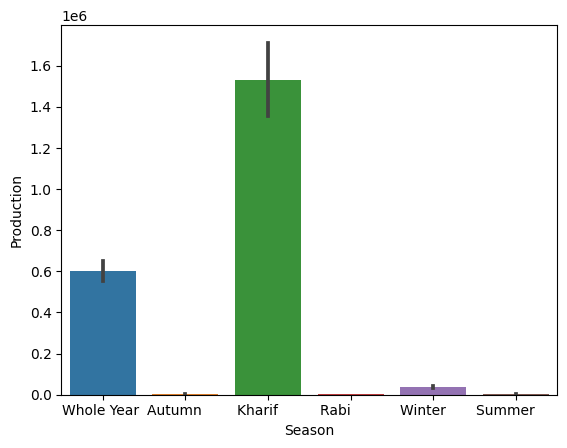

In [26]:
sns.barplot(x="Season",y="Production",data=sug_df)

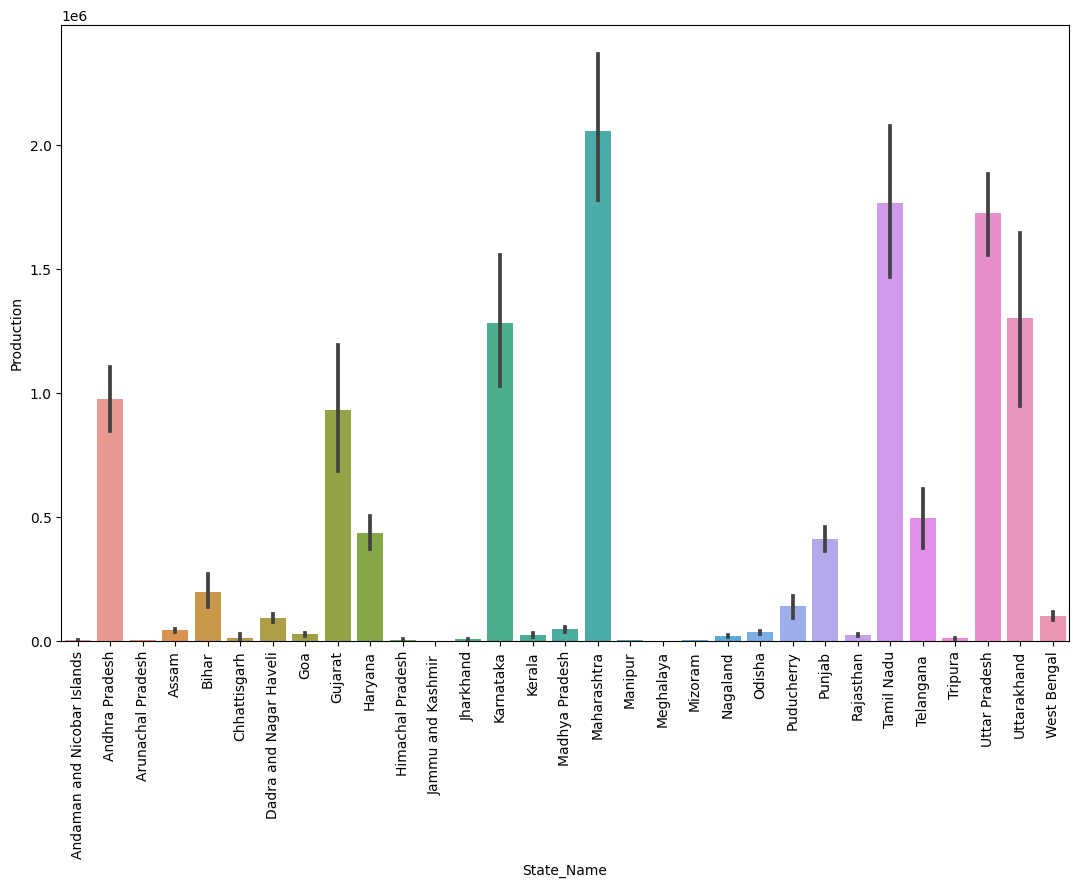

In [27]:
plt.figure(figsize=(13,8))
sns.barplot(x="State_Name",y="Production",data=sug_df)
plt.xticks(rotation=90)
plt.show()

In [28]:
top_sug_pro_dis = sug_df.groupby("District_Name")["Production"].sum().reset_index().sort_values(
    by='Production',ascending=False)
top_sug_pro_dis[:5]
sum_max = top_sug_pro_dis["Production"].sum()
top_sug_pro_dis["precent_of_pro"] = top_sug_pro_dis["Production"].map(lambda x:(x/sum_max)*100)
top_sug_pro_dis[:5]

,District_Name,Production,precent_of_pro
360,MUZAFFARNAGAR,258698795.0,4.673296
81,BIJNOR,230907185.0,4.171251
283,KHERI,224383685.0,4.053407
63,BELGAUM,198207649.0,3.580546
294,KOLHAPUR,157210426.0,2.839947


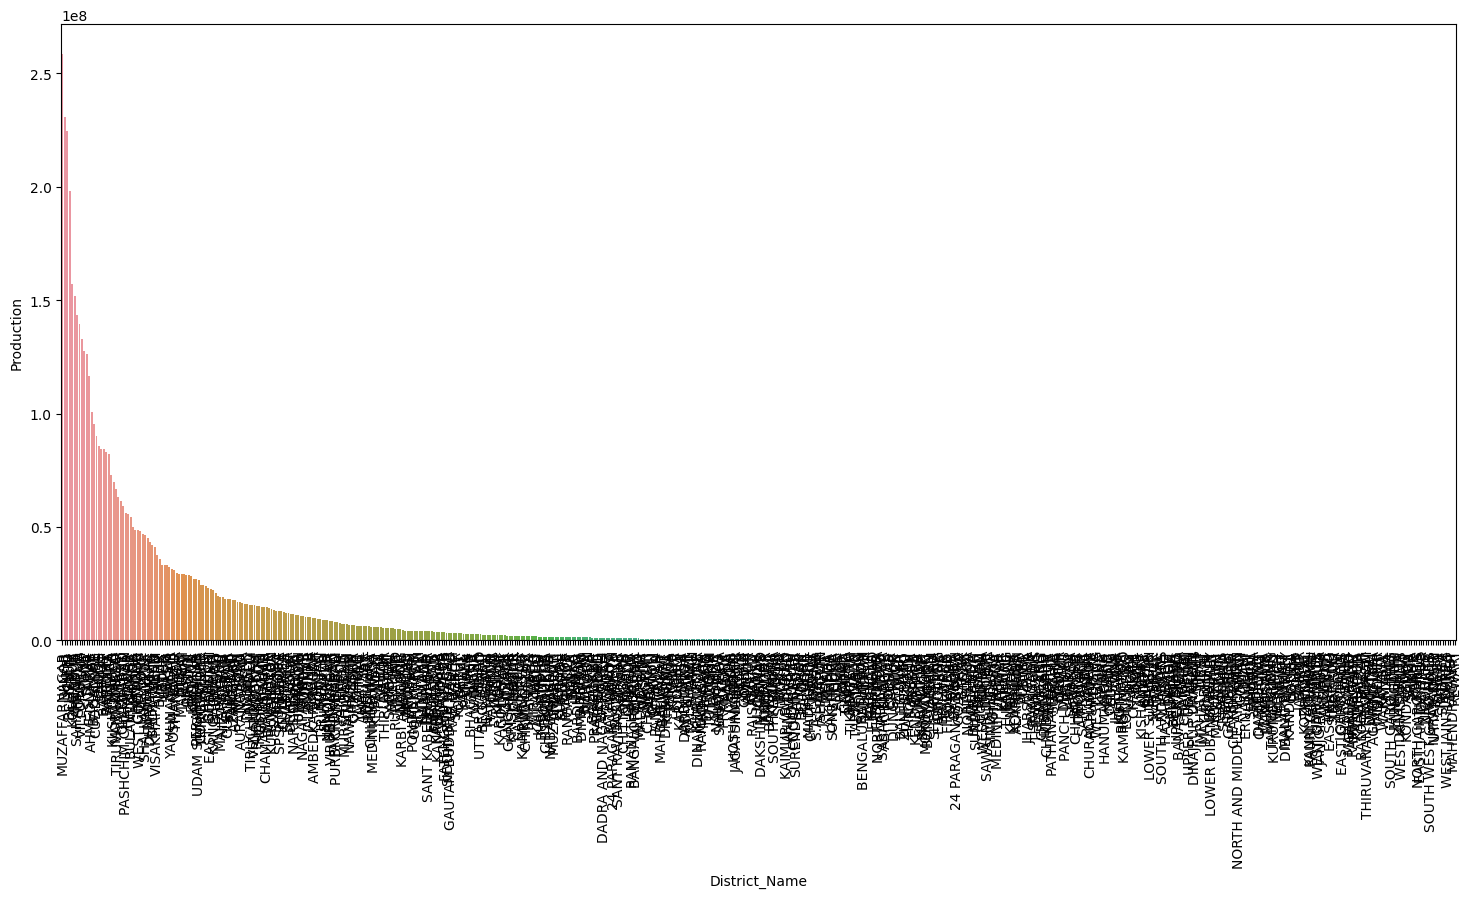

In [29]:
plt.figure(figsize=(18,8))
sns.barplot(x="District_Name",y="Production",data=top_sug_pro_dis)
plt.xticks(rotation=90)
plt.show()

In [30]:
data1 = data.drop(["District_Name","Crop_Year"],axis=1)

In [31]:
data_dum = pd.get_dummies(data1)
data_dum[:5]

,Area,Production,State_Name_Andaman and Nicobar Islands,State_Name_Andhra Pradesh,State_Name_Arunachal Pradesh,State_Name_Assam,State_Name_Bihar,State_Name_Chandigarh,State_Name_Chhattisgarh,State_Name_Dadra and Nagar Haveli,...,Crop_Turmeric,Crop_Turnip,Crop_Urad,Crop_Varagu,Crop_Water Melon,Crop_Wheat,Crop_Yam,Crop_other fibres,Crop_other misc. pulses,Crop_other oilseeds
0,1254.0,2000.0,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2.0,1.0,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,102.0,321.0,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,176.0,641.0,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,720.0,165.0,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [32]:
x = data_dum.drop("Production",axis=1)
y = data_dum[["Production"]]
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.33, random_state=42)
print("x_train :",x_train.shape)
print("x_test :",x_test.shape)
print("y_train :",y_train.shape)
print("y_test :",y_test.shape)
x_train[:5]

x_train : (162381, 164)
x_test : (79980, 164)
y_train : (162381, 1)
y_test : (79980, 1)


,Area,State_Name_Andaman and Nicobar Islands,State_Name_Andhra Pradesh,State_Name_Arunachal Pradesh,State_Name_Assam,State_Name_Bihar,State_Name_Chandigarh,State_Name_Chhattisgarh,State_Name_Dadra and Nagar Haveli,State_Name_Goa,...,Crop_Turmeric,Crop_Turnip,Crop_Urad,Crop_Varagu,Crop_Water Melon,Crop_Wheat,Crop_Yam,Crop_other fibres,Crop_other misc. pulses,Crop_other oilseeds
4843,785.0,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
20626,1250.0,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
240277,2.0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
20664,60.0,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
157859,605.0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [33]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train,y_train)

LinearRegression()

In [34]:
preds = model.predict(x_test)

In [35]:
from sklearn.metrics import mean_squared_error, r2_score
mean_squared_error(y_test,preds)
r2_score(y_test,preds)

0.14641046241956357

In [36]:
tst = test.drop(["District_Name","Crop_Year"],axis=1)
tst_dum = pd.get_dummies(tst)
tst_dum[:5]

,Area,State_Name_Andaman and Nicobar Islands,State_Name_Andhra Pradesh,State_Name_Arunachal Pradesh,State_Name_Assam,State_Name_Bihar,State_Name_Chandigarh,State_Name_Chhattisgarh,State_Name_Goa,State_Name_Gujarat,...,Crop_Soyabean,Crop_Sugarcane,Crop_Sunflower,Crop_Sweet potato,Crop_Tapioca,Crop_Tobacco,Crop_Turmeric,Crop_Urad,Crop_Wheat,Crop_other oilseeds
46,795.67,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
51,17.00,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
623,1000.00,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
630,1000.00,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
698,8.00,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [37]:
y_test = tst_dum.copy()
print(x_train.shape)
print(y_test.shape)

(162381, 164)
(3730, 92)


In [38]:
def common_member(x_train,x_test): 
    a_set =  set(x_train.columns.tolist())
    b_set =  set(x_test.columns.tolist())
    if (a_set & b_set): 
        return list(a_set & b_set) 

In [39]:
com_fea = common_member(x_train,tst_dum)
len(com_fea)

92

In [40]:
preds

array([[ -404310.14121041],
       [  110043.69165876],
       [  -88858.36704062],
       ...,
       [  350935.53790917],
       [-1265127.64194956],
       [  144114.63990723]])

In [42]:
x_test["production"] = preds

In [43]:
x_test[:10]

,Area,State_Name_Andaman and Nicobar Islands,State_Name_Andhra Pradesh,State_Name_Arunachal Pradesh,State_Name_Assam,State_Name_Bihar,State_Name_Chandigarh,State_Name_Chhattisgarh,State_Name_Dadra and Nagar Haveli,State_Name_Goa,...,Crop_Turnip,Crop_Urad,Crop_Varagu,Crop_Water Melon,Crop_Wheat,Crop_Yam,Crop_other fibres,Crop_other misc. pulses,Crop_other oilseeds,production
51163,5467.0,False,False,False,False,False,False,True,False,False,...,False,False,False,False,True,False,False,False,False,-4.043101e+05
55141,830.0,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,1.100437e+05
104122,9.0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,-8.885837e+04
161230,13.0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,-2.691271e+06
229232,117.0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,4.792050e+04
235076,52.0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2.929932e+05
219586,62313.0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,2.179054e+05
54184,736.0,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,1.007862e+05
6591,87.0,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,6.123109e+05
33355,366.0,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1.660982e+05


In [44]:
x_test.to_csv('Prediction.csv')